In [ ]:
!pip install ultralytics torchmetrics
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import shutil
import random
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from ultralytics import YOLO
from torchmetrics.detection.mean_ap import MeanAveragePrecision

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Đang sử dụng thiết bị: {device}")

Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Đang sử dụng thiết bị: cuda


In [ ]:
import os, glob, shutil, yaml
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# --- Đường dẫn ---
ROOT_DIR = "/content/drive/MyDrive/tomato_yolo_dataset"  # chứa folders: images/, labels/
RAW_IMAGES = os.path.join(ROOT_DIR, "images")
RAW_LABELS = os.path.join(ROOT_DIR, "labels")

WORK_DIR = "/content/drive/MyDrive/tomato_final_split"   # output sau khi chia train/val/test
output_dataset_path = WORK_DIR

# --- Tên lớp: khớp 100% với nhãn YOLO (theo ảnh/thống kê) ---
CLASS_NAMES = [
    "Tomato__Bacterial_spot",
    "Tomato_Early_blight",
    "Tomato__Late_blight",
    "Tomato__Leaf_Mold",
    "Tomato__Septoria_leaf_spot",
    "Tomato__Spider_mites Two-spotted_spider_mite",
    "Tomato__Target_Spot",
    "Tomato__Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato__Tomato_mosaic_virus",
    "Tomato___healthy"
]

# --- Chia dữ liệu 70/15/15 & copy sang WORK_DIR ---
def prepare_data():
    all_imgs = glob.glob(os.path.join(RAW_IMAGES, "*.jpg"))
    pairs = []
    for img in all_imgs:
        lbl = os.path.join(RAW_LABELS, os.path.basename(img).replace(".jpg", ".txt"))
        if os.path.exists(lbl):
            pairs.append((img, lbl))

    train_val, test_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
    train_pairs, val_pairs = train_test_split(train_val, test_size=0.176, random_state=42)  # ~15%

    if os.path.exists(WORK_DIR):
        n_train = len(glob.glob(os.path.join(WORK_DIR, "images/train", "*.jpg")))
        n_val   = len(glob.glob(os.path.join(WORK_DIR, "images/val",   "*.jpg")))
        n_test  = len(glob.glob(os.path.join(WORK_DIR, "images/test",  "*.jpg")))
        if n_train == len(train_pairs) and n_val == len(val_pairs) and n_test == len(test_pairs):
            print(f"Dữ liệu đã tồn tại (Train:{n_train}, Val:{n_val}, Test:{n_test}). Bỏ qua sao chép.")
            return

    print(f"Sao chép dữ liệu (Train:{len(train_pairs)}, Val:{len(val_pairs)}, Test:{len(test_pairs)})...")
    if os.path.exists(WORK_DIR):
        shutil.rmtree(WORK_DIR)

    for split, spairs in zip(["train", "val", "test"], [train_pairs, val_pairs, test_pairs]):
        img_dst = os.path.join(WORK_DIR, "images", split)
        lbl_dst = os.path.join(WORK_DIR, "labels", split)
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)
        for img_src, lbl_src in spairs:
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)

    print("Hoàn tất chuẩn bị dữ liệu.")

# --- Ghi file cấu hình YOLO ---
def write_yolo_yaml():
    yaml_content = {
        "path": WORK_DIR,
        "train": "images/train",
        "val":   "images/val",
        "test":  "images/test",
        "nc": 10,
        "names": CLASS_NAMES
    }
    yaml_path = os.path.join(WORK_DIR, "tomato.yaml")
    with open(yaml_path, "w", encoding="utf-8") as f:
        yaml.dump(yaml_content, f, sort_keys=False, allow_unicode=True)
    print(f"Đã tạo file config: {yaml_path}")

# --- Vẽ 2 biểu đồ (cột & cột ngang) ---
def plot_two_charts(class_counts, class_names, split_name, save_path=None):
    counts = [class_counts.get(i, 0) for i in range(len(class_names))]
    n = len(class_names)
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    max_c = max(counts) if counts else 0
    pad = (max_c * 0.01) if max_c > 0 else 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.bar(range(n), counts, color=colors)
    ax1.set_title(f"{split_name} Set - Annotations per Class", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Class ID"); ax1.set_ylabel("Number of Annotations")
    ax1.set_xticks(range(n))
    for i, c in enumerate(counts):
        ax1.text(i, c + pad, str(c), ha="center", fontsize=9)

    short_names = [name.replace("Tomato__", "").replace("Tomato_", "") for name in class_names]
    ax2.barh(short_names, counts, color=colors)
    ax2.set_title(f"{split_name} Set - Distribution by Disease", fontsize=14, fontweight="bold")
    for y, c in enumerate(counts):
        ax2.text(c + pad, y, str(c), va="center", fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# --- Phân tích phân bố lớp từ nhãn YOLO ---
def analyze_distribution(labels_dir, split_name):
    class_counts = Counter()
    images_with_multiple_classes = 0
    total_annotations = 0

    label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]
    for lf in label_files:
        classes_in_img = set()
        with open(os.path.join(labels_dir, lf), "r", encoding="utf-8") as f:
            lines = f.readlines()
            total_annotations += len(lines)
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue
                cid = int(parts[0])
                class_counts[cid] += 1
                classes_in_img.add(cid)
        if len(classes_in_img) > 1:
            images_with_multiple_classes += 1

    # Tóm tắt gọn
    print("\n" + "="*70)
    print(f"{split_name.upper()} SET - CLASS DISTRIBUTION")
    print("="*70)
    print(f"Total images: {len(label_files)}")
    print(f"Total annotations: {total_annotations}")
    print(f"Images with multiple classes: {images_with_multiple_classes}")
    print(f"\n{'Class ID':<10}{'Class Name':<45}{'Count':<10}")
    print("="*70)
    for i, name in enumerate(CLASS_NAMES):
        cnt = class_counts.get(i, 0)
        perc = (cnt / total_annotations * 100) if total_annotations else 0
        print(f"{i:<10}{name:<45}{cnt:<10}({perc:.1f}%)")
    print("="*70)

    # Vẽ biểu đồ
    save_path = f"/content/class_distribution_{split_name.lower()}.png"
    plot_two_charts(class_counts, CLASS_NAMES, split_name, save_path)

    # Kiểm tra mất cân bằng
    counts = [class_counts.get(i, 0) for i in range(len(CLASS_NAMES))]
    nonzero = [c for c in counts if c > 0]
    if nonzero:
        max_c, min_c = max(nonzero), min(nonzero)
        ratio = max_c / min_c if min_c > 0 else float("inf")
        print(f"Most frequent class: {CLASS_NAMES[counts.index(max_c)]} ({max_c})")
        print(f"Least  frequent class: {CLASS_NAMES[counts.index(min_c)]} ({min_c})")
        print(f"Imbalance ratio: {ratio:.2f}:1")


Dữ liệu đã tồn tại (Train:12717, Val:2717, Test:2724). Bỏ qua sao chép.
Đã tạo file config: /content/drive/MyDrive/tomato_final_split/tomato.yaml

TRAINING SET - CLASS DISTRIBUTION
Total images: 12717
Total annotations: 12734
Images with multiple classes: 0

Class ID  Class Name                                   Count     
0         Tomato__Bacterial_spot                       1453      (11.4%)
1         Tomato_Early_blight                          714       (5.6%)
2         Tomato__Late_blight                          1320      (10.4%)
3         Tomato__Leaf_Mold                            661       (5.2%)
4         Tomato__Septoria_leaf_spot                   1269      (10.0%)
5         Tomato__Spider_mites Two-spotted_spider_mite 1221      (9.6%)
6         Tomato__Target_Spot                          968       (7.6%)
7         Tomato__Tomato_Yellow_Leaf_Curl_Virus        3761      (29.5%)
8         Tomato__Tomato_mosaic_virus                  259       (2.0%)
9         Tomato___heal

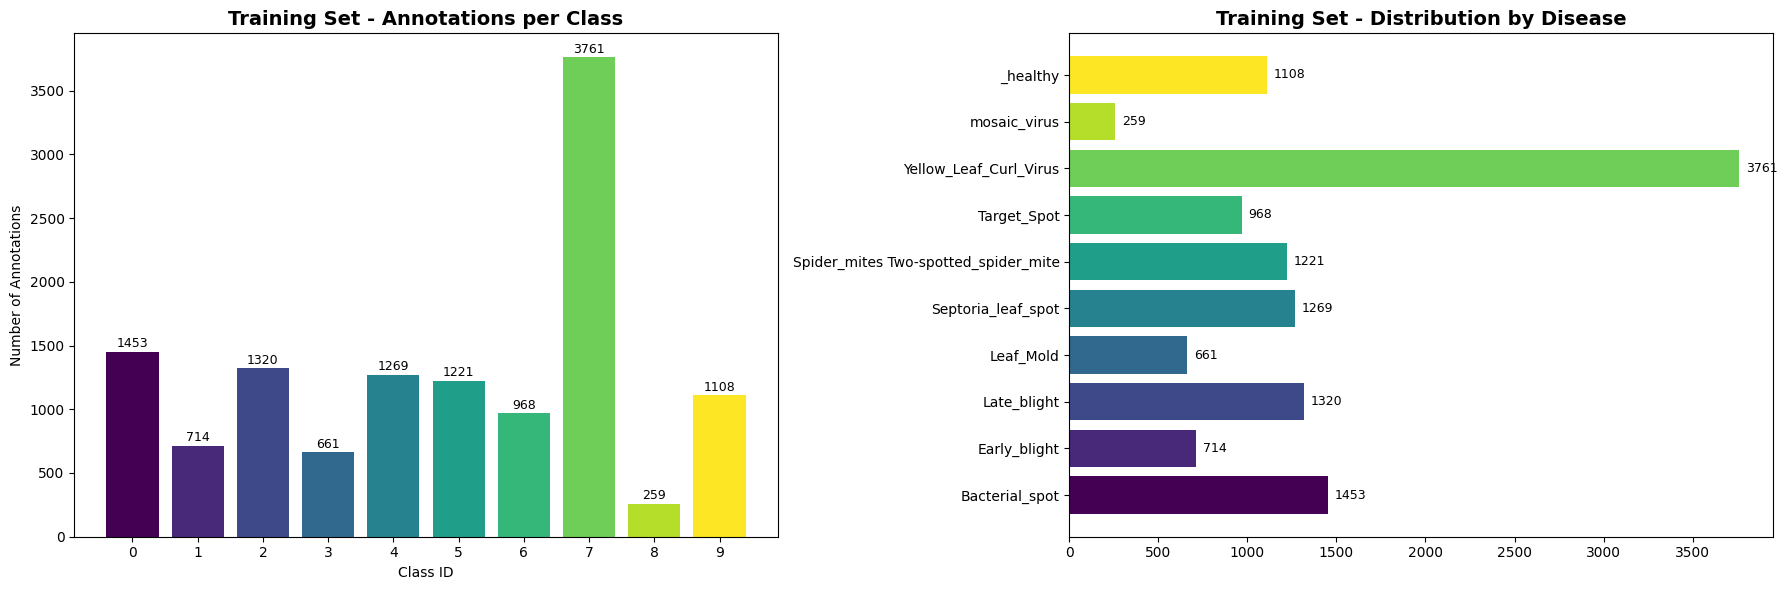

Most frequent class: Tomato__Tomato_Yellow_Leaf_Curl_Virus (3761)
Least  frequent class: Tomato__Tomato_mosaic_virus (259)
Imbalance ratio: 14.52:1

VALIDATION SET - CLASS DISTRIBUTION
Total images: 2717
Total annotations: 2719
Images with multiple classes: 0

Class ID  Class Name                                   Count     
0         Tomato__Bacterial_spot                       329       (12.1%)
1         Tomato_Early_blight                          156       (5.7%)
2         Tomato__Late_blight                          280       (10.3%)
3         Tomato__Leaf_Mold                            148       (5.4%)
4         Tomato__Septoria_leaf_spot                   273       (10.0%)
5         Tomato__Spider_mites Two-spotted_spider_mite 215       (7.9%)
6         Tomato__Target_Spot                          195       (7.2%)
7         Tomato__Tomato_Yellow_Leaf_Curl_Virus        821       (30.2%)
8         Tomato__Tomato_mosaic_virus                  57        (2.1%)
9         Tomato___he

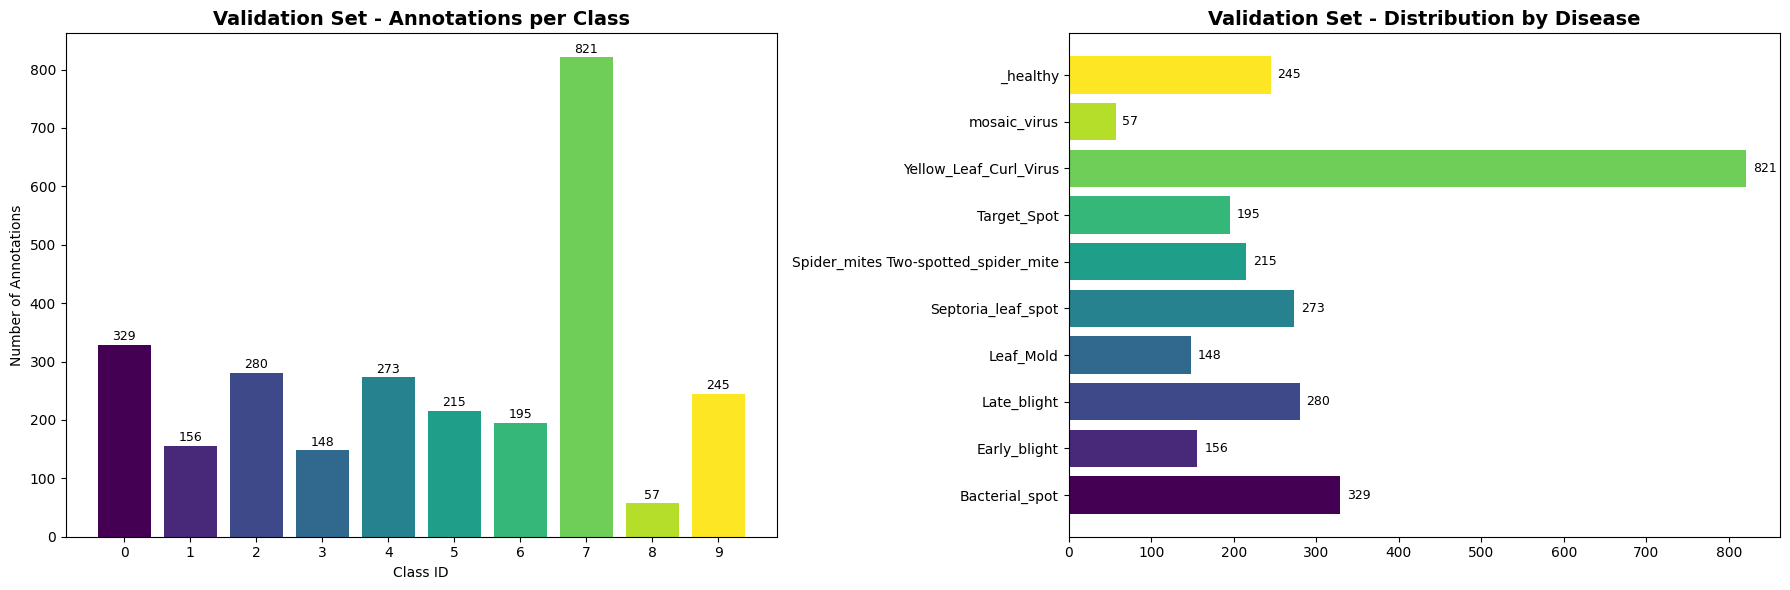

Most frequent class: Tomato__Tomato_Yellow_Leaf_Curl_Virus (821)
Least  frequent class: Tomato__Tomato_mosaic_virus (57)
Imbalance ratio: 14.40:1

TESTING SET - CLASS DISTRIBUTION
Total images: 2724
Total annotations: 2726
Images with multiple classes: 0

Class ID  Class Name                                   Count     
0         Tomato__Bacterial_spot                       345       (12.7%)
1         Tomato_Early_blight                          134       (4.9%)
2         Tomato__Late_blight                          311       (11.4%)
3         Tomato__Leaf_Mold                            143       (5.2%)
4         Tomato__Septoria_leaf_spot                   236       (8.7%)
5         Tomato__Spider_mites Two-spotted_spider_mite 241       (8.8%)
6         Tomato__Target_Spot                          242       (8.9%)
7         Tomato__Tomato_Yellow_Leaf_Curl_Virus        779       (28.6%)
8         Tomato__Tomato_mosaic_virus                  57        (2.1%)
9         Tomato___healthy 

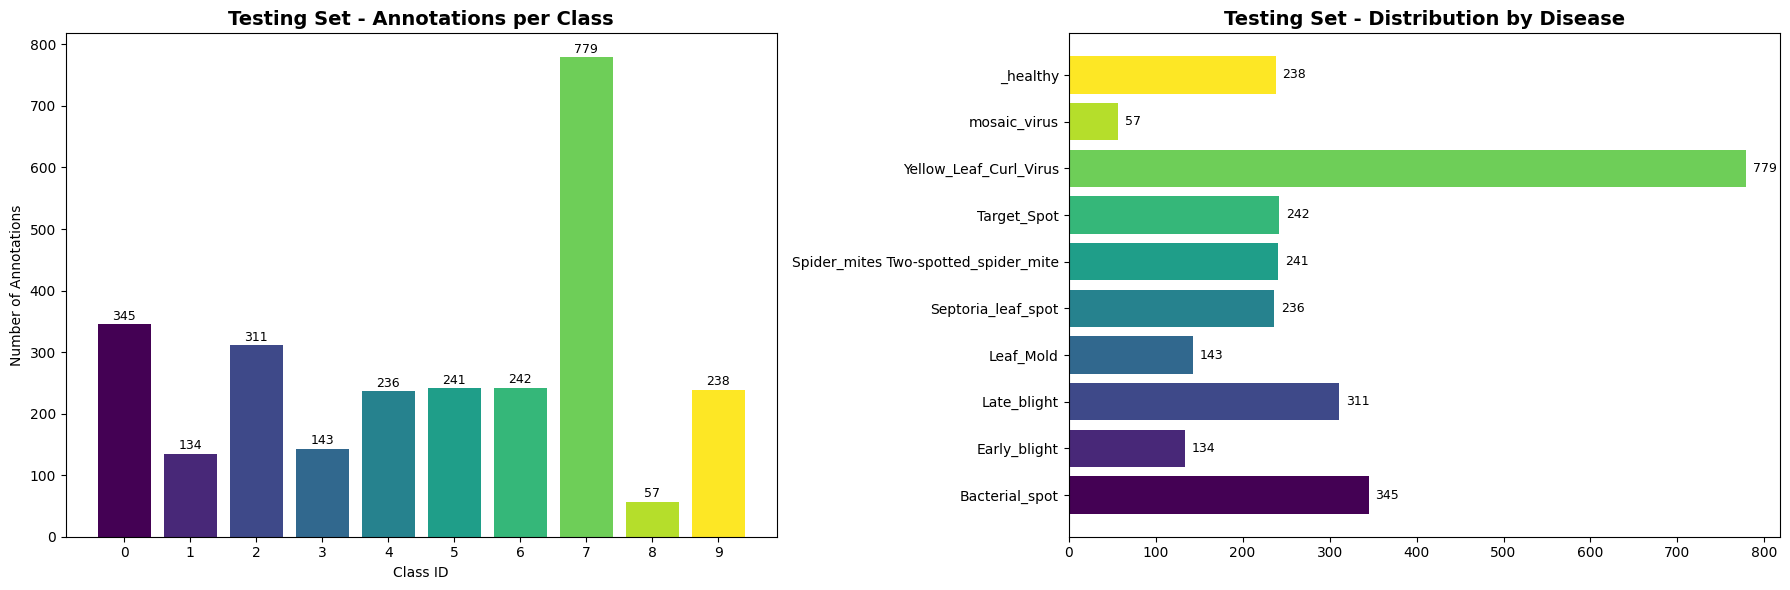

Most frequent class: Tomato__Tomato_Yellow_Leaf_Curl_Virus (779)
Least  frequent class: Tomato__Tomato_mosaic_virus (57)
Imbalance ratio: 13.67:1


In [ ]:
# 1) Chia & copy dữ liệu
prepare_data()

# 2) Ghi file cấu hình cho YOLO
write_yolo_yaml()

# 3) Phân tích & vẽ biểu đồ cho Train, Val và Test
analyze_distribution(os.path.join(output_dataset_path, "labels/train"), "Training")
analyze_distribution(os.path.join(output_dataset_path, "labels/val"),   "Validation")
analyze_distribution(os.path.join(output_dataset_path, "labels/test"),  "Testing")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
from ultralytics import YOLO

# --- 1. HUẤN LUYỆN YOLOv8s ---
print("\n--- BAT DAU HUAN LUYEN YOLOv8s ---")
model_yolo = YOLO('yolov8s.pt')

# Train
results_yolo = model_yolo.train(
    data=yaml_path,
    epochs=15,
    imgsz=256,
    batch=16,
    project='/content/runs/detect',
    name='tomato_yolov8s',
    verbose=True,
    plots=True # Bắt buộc True để YOLO tự vẽ biểu đồ loss và confusion matrix
)

# --- 2. ĐÁNH GIÁ TRÊN TẬP TEST ---
print("\n--- BAT DAU DANH GIA (EVALUATION) ---")
metrics_yolo = model_yolo.val(split='test')

# Lấy các chỉ số quan trọng
yolo_map50 = metrics_yolo.box.map50
yolo_map50_95 = metrics_yolo.box.map
yolo_precision = metrics_yolo.box.mp
yolo_recall = metrics_yolo.box.mr
# F1-Score trung bình (tính toán từ Precision và Recall)
yolo_f1 = 2 * (yolo_precision * yolo_recall) / (yolo_precision + yolo_recall + 1e-7)

print(f"\nKET QUA TONG HOP:")
print(f"   mAP@50:    {yolo_map50:.4f}")
print(f"   Precision: {yolo_precision:.4f}")
print(f"   Recall:    {yolo_recall:.4f}")
print(f"   F1-Score:  {yolo_f1:.4f}")


--- BAT DAU HUAN LUYEN YOLOv8s ---
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/tomato_final_split/tomato.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tomato_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto


--- VE BIEU DO DANH GIA ---


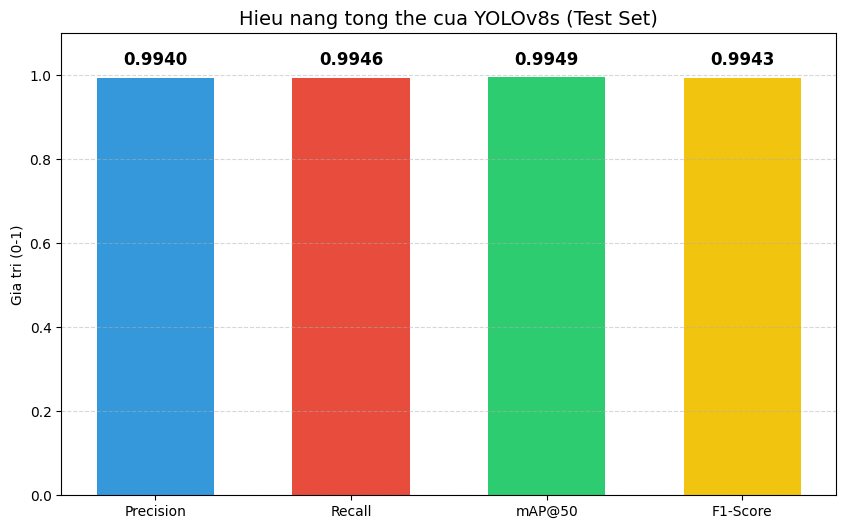

Dang doc ket qua tu: /content/runs/detect/val


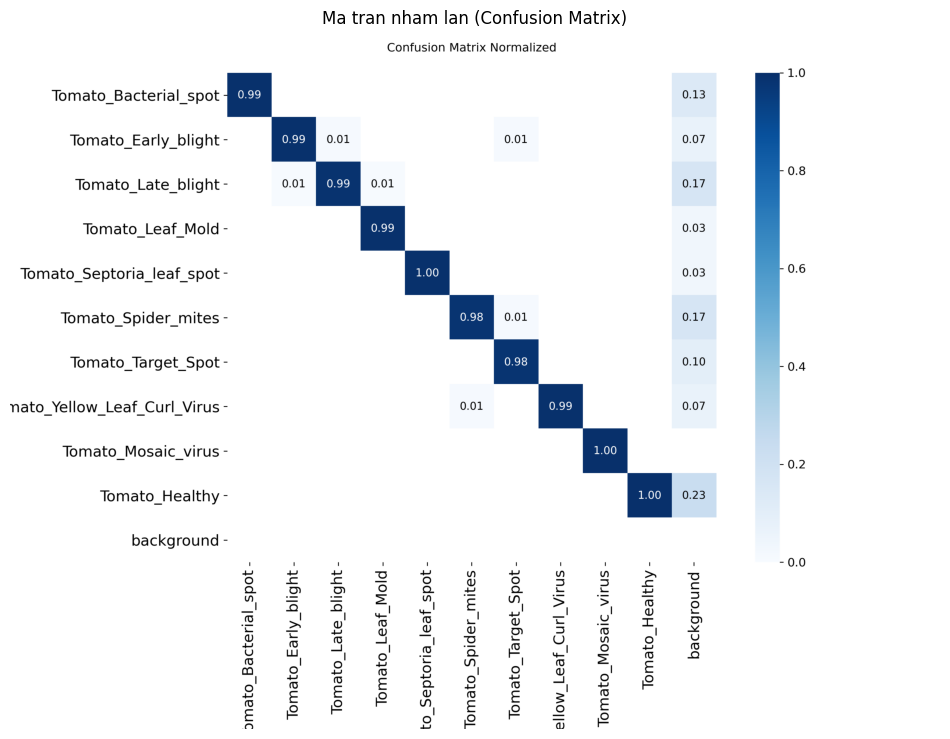

Đang đọc dữ liệu từ: /content/runs/detect/tomato_yolov8s/results.csv


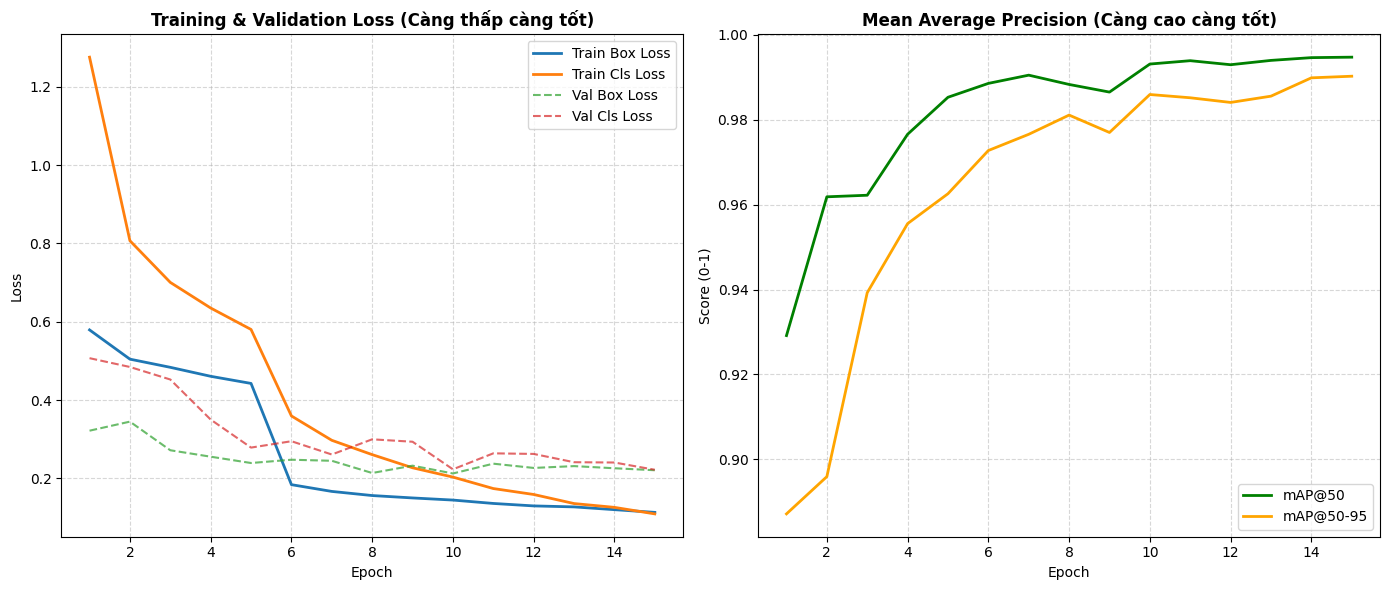


Kết quả tại Epoch cuối (15.0):
   - mAP@50:    0.9948
   - mAP@50-95: 0.9903


In [ ]:
# --- 3. VẼ BIỂU ĐỒ TRỰC QUAN (VISUALIZATION) ---
import pandas as pd
print("\n--- VE BIEU DO DANH GIA ---")
csv_files = glob.glob('/content/runs/detect/*/results.csv')
# A. Biểu đồ cột so sánh các chỉ số tổng hợp
metrics_names = ['Precision', 'Recall', 'mAP@50', 'F1-Score']
metrics_values = [yolo_precision, yolo_recall, yolo_map50, yolo_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=colors, width=0.6)
plt.ylim(0, 1.1)
plt.title('Hieu nang tong the cua YOLOv8s (Test Set)', fontsize=14)
plt.ylabel('Gia tri (0-1)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Viết số lên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()

# B. Hiển thị các biểu đồ YOLO tự sinh ra (Confusion Matrix & Training Results)
# Tìm đường dẫn folder run mới nhất
try:
    # Lấy folder mới nhất trong runs/detect/
    list_of_dirs = glob.glob('/content/runs/detect/*')
    if not list_of_dirs:
        raise FileNotFoundError("Khong tim thay folder runs/detect/")

    latest_run = max(list_of_dirs, key=os.path.getmtime)
    print(f"Dang doc ket qua tu: {latest_run}")

    # 1. Hiển thị Ma trận nhầm lẫn (Confusion Matrix)
    cm_path = os.path.join(latest_run, 'confusion_matrix_normalized.png')
    # Nếu không có normalized thì lấy bản thường
    if not os.path.exists(cm_path):
        cm_path = os.path.join(latest_run, 'confusion_matrix.png')

    if os.path.exists(cm_path):
        plt.figure(figsize=(12, 10))
        img_cm = cv2.imread(cm_path)
        if img_cm is not None:
            plt.imshow(cv2.cvtColor(img_cm, cv2.COLOR_BGR2RGB))
            plt.title("Ma tran nham lan (Confusion Matrix)")
            plt.axis('off')
            plt.show()
        else:
            print(f"Khong doc duoc anh tai {cm_path}")
    else:
        print("Khong tim thay file Confusion Matrix.")
except Exception as e:
    print(f"Loi khi hien thi Confusion Matrix: {e}")

if len(csv_files) == 0:
    print("Không tìm thấy file results.csv. Có thể quá trình train bị lỗi ngay từ đầu.")
else:
    # Lấy file csv thuộc folder mới nhất
    latest_csv = max(csv_files, key=os.path.getctime)
    print(f"Đang đọc dữ liệu từ: {latest_csv}")

    # 2. Đọc dữ liệu
    df = pd.read_csv(latest_csv)
    # Quan trọng: Xóa khoảng trắng thừa trong tên cột của YOLO
    df.columns = df.columns.str.strip()

    # 3. Vẽ biểu đồ
    plt.figure(figsize=(14, 6))

    # --- Biểu đồ 1: Loss (Mất mát) ---
    plt.subplot(1, 2, 1)
    if 'train/box_loss' in df.columns:
        plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linewidth=2)
    if 'train/cls_loss' in df.columns:
        plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', linewidth=2)

    # Kiểm tra xem có Val loss không để vẽ
    if 'val/box_loss' in df.columns:
        plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linestyle='--', alpha=0.7)
    if 'val/cls_loss' in df.columns:
        plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', linestyle='--', alpha=0.7)

    plt.title('Training & Validation Loss (Càng thấp càng tốt)', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- Biểu đồ 2: Metrics (Độ chính xác) ---
    plt.subplot(1, 2, 2)
    if 'metrics/mAP50(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='green', linewidth=2)
    if 'metrics/mAP50-95(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', color='orange', linewidth=2)

    plt.title('Mean Average Precision (Càng cao càng tốt)', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Score (0-1)')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # In ra kết quả epoch cuối cùng
    if not df.empty:
        print(f"\nKết quả tại Epoch cuối ({df.iloc[-1]['epoch']}):")
        if 'metrics/mAP50(B)' in df.columns:
            print(f"   - mAP@50:    {df.iloc[-1]['metrics/mAP50(B)']:.4f}")
        if 'metrics/mAP50-95(B)' in df.columns:
            print(f"   - mAP@50-95: {df.iloc[-1]['metrics/mAP50-95(B)']:.4f}")

In [ ]:
# --- DATASET CUSTOM CHO FASTER R-CNN ---
class TomatoRCNNDataset(Dataset):
    def __init__(self, img_dir, label_dir, width, height, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.width = width
        self.height = height
        self.transforms = transforms
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __getitem__(self, idx):
        # 1. Load ảnh
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Lấy kích thước gốc để tính lại bbox
        h_org, w_org, _ = img.shape

        # 2. Resize ảnh (Tiền xử lý)
        img_resized = cv2.resize(img, (self.width, self.height))
        img_tensor = T.ToTensor()(img_resized) # Chuyển về Tensor và Normalize (0-1)

        # 3. Xử lý Label
        label_name = img_name.replace(".jpg", ".txt")
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    cls_id = int(parts[0]) + 1 # Class 0 là background, nên bệnh bắt đầu từ 1
                    cx, cy, w, h = parts[1:]

                    x1 = (cx - w/2) * self.width
                    y1 = (cy - h/2) * self.height
                    x2 = (cx + w/2) * self.width
                    y2 = (cy + h/2) * self.height

                    boxes.append([x1, y1, x2, y2])
                    labels.append(cls_id)

        target = {}
        if len(boxes) > 0:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        else:
            # Xử lý ảnh không có bệnh (background only)
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((0,), dtype=torch.int64)

        target["image_id"] = torch.tensor([idx])

        return img_tensor, target

    def __len__(self):
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

# Tạo Dataloader cho Faster R-CNN
train_ds_rcnn = TomatoRCNNDataset(
    os.path.join(WORK_DIR, 'images/train'),
    os.path.join(WORK_DIR, 'labels/train'),
    256, 256
)
val_ds_rcnn = TomatoRCNNDataset(
    os.path.join(WORK_DIR, 'images/test'), # Dùng tập Test để đánh giá cuối cùng cho công bằng
    os.path.join(WORK_DIR, 'labels/test'),
    256, 256
)

train_loader_rcnn = DataLoader(train_ds_rcnn, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader_rcnn = DataLoader(val_ds_rcnn, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
# --- CẤU HÌNH MODEL FASTER R-CNN ---
def get_rcnn_model(num_classes):
    # Load model pre-trained trên COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Thay thế đầu ra cho phù hợp số class của bạn (10 bệnh + 1 background)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

print("\n========== TRAINING FASTER R-CNN ==========")
num_classes = 11 # 10 bệnh + 1 background
model_rcnn = get_rcnn_model(num_classes).to(device)

# Optimizer
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training Loop
num_epochs = 10 # Train 10 epochs
rcnn_loss_history = []

for epoch in range(num_epochs):
    model_rcnn.train()
    epoch_loss = 0
    for images, targets in train_loader_rcnn:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_loss = epoch_loss / len(train_loader_rcnn)
    rcnn_loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

print("Faster R-CNN Training Completed!")


========== TRAINING FASTER R-CNN ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 83.6MB/s]


Epoch 1/10 - Loss: 0.0683
Epoch 2/10 - Loss: 0.0317
Epoch 3/10 - Loss: 0.0232
Epoch 4/10 - Loss: 0.0200
Epoch 5/10 - Loss: 0.0181
Epoch 6/10 - Loss: 0.0167
Epoch 7/10 - Loss: 0.0161
Epoch 8/10 - Loss: 0.0156
Epoch 9/10 - Loss: 0.0149
Epoch 10/10 - Loss: 0.0149
Faster R-CNN Training Completed!



--- EVALUATING FASTER R-CNN ---
Dang tinh F1-Score...
Faster R-CNN Results: mAP@50=0.9807, F1-Score=0.9390


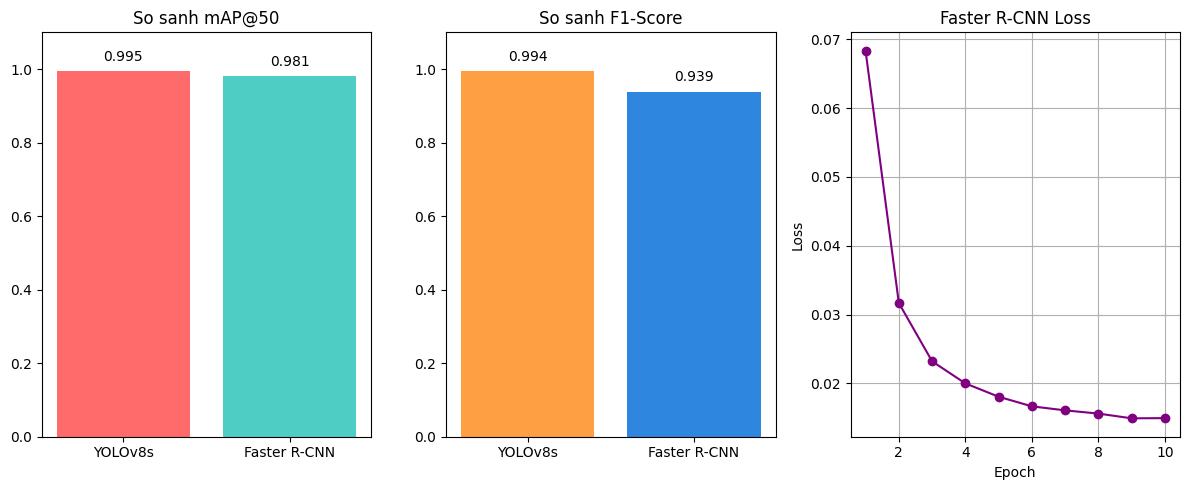


--- TONG KET ---
1. YOLOv8s:     mAP@50=0.995, F1-Score=0.994
2. Faster RCNN: mAP@50=0.981, F1-Score=0.939


In [ ]:
# --- BLOCK 6: ĐÁNH GIÁ & SO SÁNH ---
import torch
import numpy as np

# Hàm tính Precision, Recall, F1 cho Faster R-CNN
def calculate_f1_rcnn(loader, model, device, conf_threshold=0.5, iou_threshold=0.5):
    model.eval()
    tp = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for images, targets in loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']

                gt_boxes = targets[i]['boxes'].to(device)
                gt_labels = targets[i]['labels'].to(device)

                # Lọc theo ngưỡng niềm tin
                keep = pred_scores > conf_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                if len(gt_boxes) == 0:
                    fp += len(pred_boxes)
                    continue

                if len(pred_boxes) == 0:
                    fn += len(gt_boxes)
                    continue

                # Tính IoU
                iou_matrix = torchvision.ops.box_iou(pred_boxes, gt_boxes)

                matched_gt = set()
                for p_idx in range(len(pred_boxes)):
                    if iou_matrix.shape[1] == 0:
                        fp += 1
                        continue

                    max_iou, g_idx = torch.max(iou_matrix[p_idx], dim=0)

                    if max_iou >= iou_threshold:
                        if pred_labels[p_idx] == gt_labels[g_idx] and g_idx.item() not in matched_gt:
                            tp += 1
                            matched_gt.add(g_idx.item())
                        else:
                            fp += 1
                    else:
                        fp += 1

                fn += len(gt_boxes) - len(matched_gt)

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return precision, recall, f1

print("\n--- EVALUATING FASTER R-CNN ---")

# 1. Tính mAP (Dùng thư viện)
metric = MeanAveragePrecision(iou_type="bbox")
model_rcnn.eval()

with torch.no_grad():
    for images, targets in val_loader_rcnn:
        images = list(img.to(device) for img in images)
        preds = model_rcnn(images)

        target_formatted = []
        for t in targets:
            target_formatted.append({
                "boxes": t["boxes"].to(device),
                "labels": t["labels"].to(device)
            })

        metric.update(preds, target_formatted)

rcnn_metrics = metric.compute()
rcnn_map50 = rcnn_metrics['map_50'].item()

# 2. Tính F1-Score (Dùng hàm tự viết)
print("Dang tinh F1-Score...")
rcnn_p, rcnn_r, rcnn_f1 = calculate_f1_rcnn(val_loader_rcnn, model_rcnn, device)

print(f"Faster R-CNN Results: mAP@50={rcnn_map50:.4f}, F1-Score={rcnn_f1:.4f}")

# --- VẼ BIỂU ĐỒ SO SÁNH ---
models = ['YOLOv8s', 'Faster R-CNN']
scores_map = [yolo_map50, rcnn_map50]
scores_f1 = [yolo_f1, rcnn_f1]

plt.figure(figsize=(12, 5))

# Biểu đồ 1: So sánh mAP@50
plt.subplot(1, 3, 1)
bars = plt.bar(models, scores_map, color=['#ff6b6b', '#4ecdc4'])
plt.title('So sanh mAP@50')
plt.ylim(0, 1.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')

# Biểu đồ 2: So sánh F1-Score
plt.subplot(1, 3, 2)
bars = plt.bar(models, scores_f1, color=['#ff9f43', '#2e86de'])
plt.title('So sanh F1-Score')
plt.ylim(0, 1.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom')

# Biểu đồ 3: Loss Curve Faster R-CNN
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), rcnn_loss_history, marker='o', color='purple')
plt.title('Faster R-CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- TONG KET ---")
print(f"1. YOLOv8s:     mAP@50={yolo_map50:.3f}, F1-Score={yolo_f1:.3f}")
print(f"2. Faster RCNN: mAP@50={rcnn_map50:.3f}, F1-Score={rcnn_f1:.3f}")

Đang xử lý ảnh: TMHE_image (922).jpg


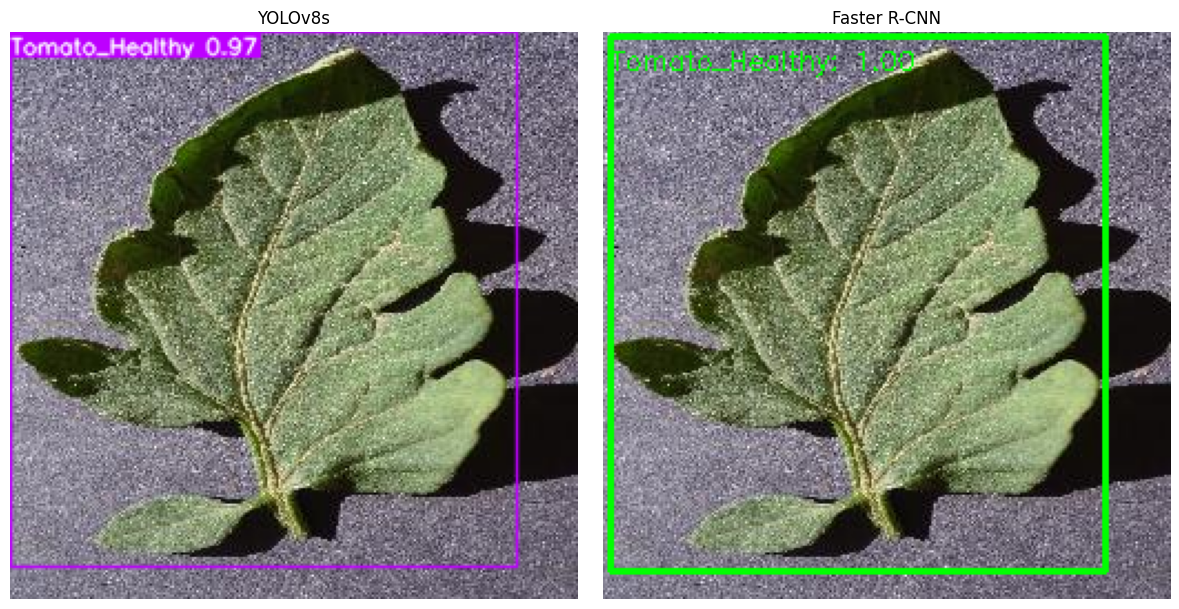

In [ ]:
# Block 7: Visualize Kết quả Dự đoán (Final Fixed Version)
import cv2
import random
import glob
import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Đảm bảo biến device tồn tại
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Lấy 1 ảnh ngẫu nhiên
test_images = glob.glob(os.path.join(WORK_DIR, 'images/test', '*.jpg'))
if len(test_images) > 0:
    sample_img_path = random.choice(test_images)
    print(f"Đang xử lý ảnh: {os.path.basename(sample_img_path)}")

    # --- 1. DỰ ĐOÁN VỚI YOLO  ---
    # Thêm imgsz=256 để đồng bộ kích thước huấn luyện
    yolo_res = model_yolo.predict(sample_img_path, imgsz=256, verbose=False)[0]
    yolo_plot = yolo_res.plot(line_width=1, font_size=14) # Ảnh BGR

    # --- 2. DỰ ĐOÁN VỚI FASTER R-CNN ---
    img_cv2 = cv2.imread(sample_img_path)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Resize về 256x256 để khớp đầu vào model
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_tensor = T.ToTensor()(img_resized).unsqueeze(0).to(device)

    model_rcnn.eval()
    with torch.no_grad():
        prediction = model_rcnn(img_tensor)[0]

    # Vẽ box lên ảnh R-CNN
    rcnn_plot = img_resized.copy()

    for i, box in enumerate(prediction['boxes']):
        score = prediction['scores'][i].item()
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()

            # Vẽ Box
            cv2.rectangle(rcnn_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Lấy tên lớp
            label_id = prediction['labels'][i].item()
            # Kiểm tra biến class_names có tồn tại không trước khi dùng
            if 'class_names' in globals() and 1 <= label_id <= len(class_names):
                label_txt = f"{class_names[label_id-1]}: {score:.2f}"

                # --- FIX: VỊ TRÍ CHỮ THÔNG MINH ---
                # Nếu box sát mép trên (y1 < 15), vẽ chữ xuống dưới để không bị mất
                text_y = y1 + 15 if y1 < 15 else y1 - 5

                cv2.putText(rcnn_plot, label_txt, (x1, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    # --- 3. HIỂN THỊ ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    # Chuyển YOLO plot từ BGR sang RGB để màu đúng
    plt.imshow(cv2.cvtColor(yolo_plot, cv2.COLOR_BGR2RGB))
    plt.title("YOLOv8s")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rcnn_plot)
    plt.title("Faster R-CNN")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy ảnh trong thư mục Test!")